In [ ]:
!earthengine authenticate

Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0709 16:46:43.882236 132218022776832 _default.py:683] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=46ij6dHyqtV5SpVg_s8Fi7EflkvDWB1mfiEPxRDqOKc&tc=-M5PgEg06f2TtJU9jdeST6F1wXIsBAvU6Xjbi7Zv-rY&cc=D8LIiZJhCYn77ui2d5JnG7823xPGge5w-OZxqxOWw5E

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: Traceback (most recent call las

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = "/content/drive/MyDrive/Data Satelit"
asset = "/content/drive/MyDrive/Data-Satelit/Aset"

In [ ]:
%pip install geopandas rasterio rasterstats shapely jenkspy jcopml gdal geemap



In [ ]:
from rasterstats.io import bounds_window
from rasterio.features import rasterize
import scipy.stats as st
import geopandas as gpd
import shapely as shp
import pandas as pd
import numpy as np
import rasterstats
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import jenkspy
import os
import geemap
import ee
import os
import numpy as np
import rasterio
import pickle
from matplotlib import colors, pyplot as plt
from rasterio.plot import show
from osgeo import gdal
#ee.Initialize()


In [ ]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
import pickle
import time
import shapely as shp
import folium
import tensorflow as tf
import seaborn as sns
from osgeo import gdal
from matplotlib import cm
from matplotlib import colors
from rasterio.plot import show
from google.colab import drive
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, accuracy_score)
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     KFold, cross_val_score, StratifiedKFold, cross_validate)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              BaggingClassifier,
                              AdaBoostClassifier)
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from scipy.stats import sem
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder


In [ ]:
landsat_asset = os.path.join(
    #asset, 'Sampel_10x10.geojson'
    asset, 'export_squares.geojson')

def get_center(path):
    training_vectors = gpd.read_file(path)
    bbox = training_vectors.total_bounds
    center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

    return training_vectors, center

training_land, center_land = get_center(landsat_asset)



In [ ]:
training_land

,id,label,geometry
0,1_1_1_1_1_0,1,"POLYGON ((103.92184 -4.56811, 103.92186 -4.568..."
1,1_1_1_1_1_1,1,"POLYGON ((103.92268 -4.56757, 103.92270 -4.567..."
2,1_1_1_1_1_2,1,"POLYGON ((103.92318 -4.56817, 103.92320 -4.568..."
3,1_1_1_1_1_3,1,"POLYGON ((103.92294 -4.56886, 103.92296 -4.568..."
4,1_1_1_1_1_4,1,"POLYGON ((103.92343 -4.56934, 103.92345 -4.569..."
...,...,...,...
1796,2_296,6,"POLYGON ((104.00761 -4.52671, 104.00763 -4.526..."
1797,2_297,6,"POLYGON ((104.00490 -4.52819, 104.00492 -4.528..."
1798,2_298,6,"POLYGON ((104.00365 -4.53008, 104.00367 -4.530..."
1799,2_299,6,"POLYGON ((104.00216 -4.53160, 104.00218 -4.531..."


In [ ]:
# Convert to Array
path_land = os.path.join(data, 'Llandsat-8-roi-2022-IHS')
raster_land = ".".join([path_land, "tif"])

In [ ]:
def all_values(x):
    return x

def get_raw(raster_file, training_vectors):
    X_raw = []
    y_raw = []
    with rasterio.open(raster_file, 'r') as src:
        for (label, geom) in zip(training_vectors['label'],
                                 training_vectors['geometry']):
            window = bounds_window(geom.bounds, src.transform)
            window_affine = src.window_transform(window)
            fsrc = src.read(window=window)

            mask = rasterize(
                [(geom, 1)],
                out_shape=fsrc.shape[1:],
                transform=window_affine,
                fill=0,
                dtype='uint8',
                all_touched=True
            ).astype(bool)

            label_pixels = np.argwhere(mask)

            for (row, col) in label_pixels:
                data = fsrc[:,row,col]
                one_x = np.nan_to_num(data, nan=1e-3)
                X_raw.append(one_x)
                y_raw.append(label)

    return X_raw, y_raw

X_raw_land, y_raw_land = get_raw(raster_land, training_land)

In [ ]:
# Band Composite Landsat
# Color = [Red, Green, Blue, NIR, SWIR1, SWIR2]
# Bands = [B4,      B3,  B2,  B5,    B6,    B7]
# Index = [0 ,      1 ,  2 ,  3 ,    4 ,     5]
# Fungi Indeks Komposit
def normalized_difference(arr, a, b):
    nd = (np.expand_dims((arr[..., a] - arr[..., b]) /
                                            (arr[..., a] + arr[..., b]),
                                            axis=1))

    return nd

# def get_evi(arr, nir, red, blue):
#     evi = (np.expand_dims(2.5 * (arr[..., nir] - arr[..., red]) /
#                           (arr[..., nir] + 6 * arr[..., red] -
#                            7.5 * arr[..., blue] + 1), axis=1))

#     return evi

def get_evi2(arr, nir, red):
    evi2 = (np.expand_dims(2.5 * (arr[..., nir] - arr[..., red]) /
                          (arr[..., nir] + 2.4 * arr[..., red]
                           +1), axis=1))

    return evi2

def get_arvi(arr, nir, red, blue):
    arvi =(np.expand_dims((arr[...,nir] - 2*arr[...,red] - arr[...,blue])/
                         (arr[...,nir] + 2*arr[...,red] - arr[...,blue]),
                          axis=1))
    return arvi

def get_savi(arr, nir, red):
    savi = (np.expand_dims(((arr[..., nir] - arr[..., red]) / ((arr[..., nir] + arr[..., red]) + 0.5))* 1.5,axis=1))

    return savi

In [ ]:
# Band Composite Landsat
# Color = [Red, Green, Blue, NIR, SWIR1, SWIR2]
# Bands = [B4,      B3,  B2,  B5,    B6,    B7]
# Index = [0 ,      1 ,  2 ,  3 ,    4 ,     5]
X_land = np.array(X_raw_land)
X_land = np.nan_to_num(X_land, nan=0)
y_land = np.array(y_raw_land)
(X_land.shape, y_land.shape)

((2058, 6), (2058,))

In [ ]:
X_land

array([[0.08374792, 0.08284334, 0.10007779, 0.20067628, 0.23207752,
        0.16370165],
       [0.08367594, 0.08380304, 0.09936107, 0.20705684, 0.24826574,
        0.17278342],
       [0.07576455, 0.076053  , 0.09167381, 0.204325  , 0.21510655,
        0.14679223],
       ...,
       [0.03365361, 0.05288872, 0.06444597, 0.27551246, 0.11630308,
        0.0447728 ],
       [0.03522259, 0.06099312, 0.06405715, 0.37445295, 0.14500616,
        0.05370915],
       [0.04037441, 0.06481197, 0.07228005, 0.30264   , 0.12786637,
        0.04701839]], dtype=float32)

In [ ]:

#1 : bangunan
#2 : tanah
#3 : hutan
#4 : nonKopi
#5 : kopi
#6 : air
lan_unique, lan_counts = np.unique(y_land, return_counts=True)
print(dict(zip(lan_unique, lan_counts)))

{1: 337, 2: 341, 3: 346, 4: 337, 5: 336, 6: 361}


In [ ]:
ndbi_land = normalized_difference(X_land, 4, 3) #(SWIR-NIR)/(SWIR+NIR)
# ndmi_land = normalized_difference(X_land, 3, 4) #(NIR-SWIR)/(NIR+SWIR)
ndvi_land = normalized_difference(X_land, 3, 0) #(NIR-RED)/(NIR+RED)
ndwi_land = normalized_difference(X_land, 1, 3) #(GREEN-NIR)/(GREEN+NIR)
#evi_land  = get_evi(X_land, 3, 0, 2) #2.5*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)
evi2_land = get_evi2(X_land, 3, 0) #2.5*(NIR-RED)/(NIR+2.4*RED+1)
arvi_land = get_arvi(X_land, 3, 0, 2) #(NIR-2*RED-BLUE)/ (NIR+2*RED-BLUE)
# savi_land = get_savi(X_land, 3, 0) #((NIR – RED) / (NIR + RED + 0.5)) * (1.5)
X_land = np.concatenate([X_land, ndbi_land, ndwi_land, ndvi_land, evi2_land, arvi_land], axis=1)

In [ ]:
X_land.shape , y_land.shape

((2058, 11), (2058,))

In [ ]:
# # Standardize data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
trans = StandardScaler()
X_land = trans.fit_transform(X_land)
# Normalized data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
normal = MinMaxScaler()
X_land = normal.fit_transform(X_land)

In [ ]:
band_land = ["(Red)B4", "(Green)B3", "(Blue)B2", "(NIR)B5", "(SWIR)B6", "(SWIR2)B7","NDBI","NDWI","NDVI", "EVI-2","ARVI"]

(Red)B4


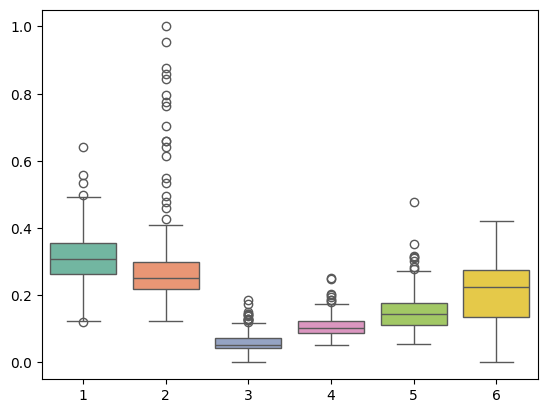

(Green)B3


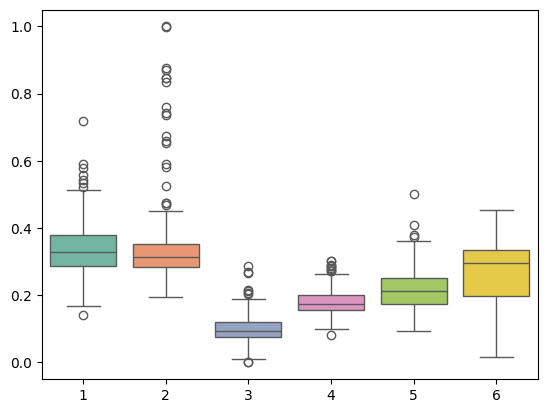

(Blue)B2


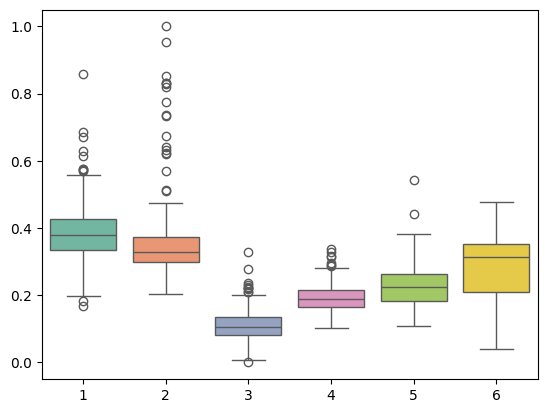

(NIR)B5


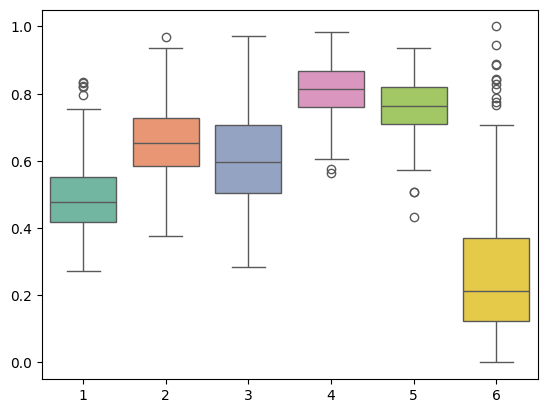

(SWIR)B6


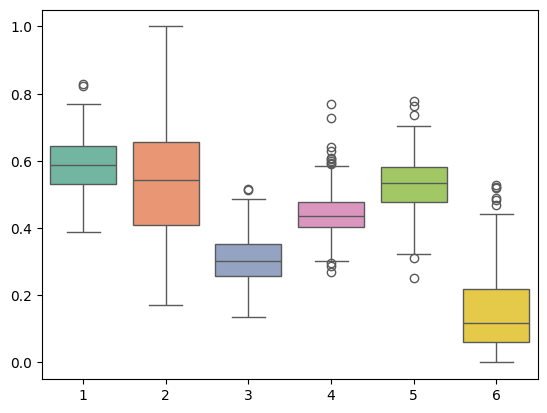

(SWIR2)B7


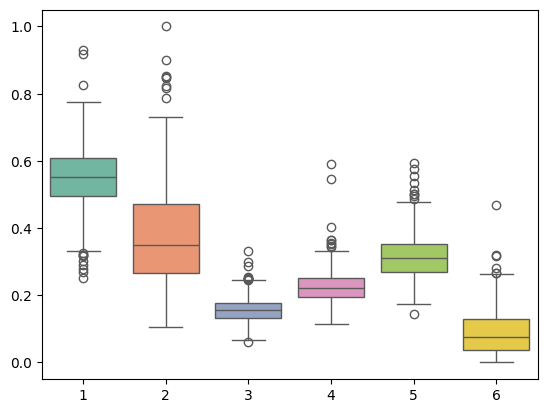

NDBI


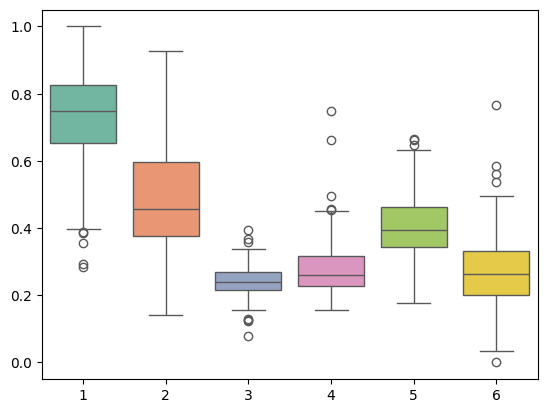

NDWI


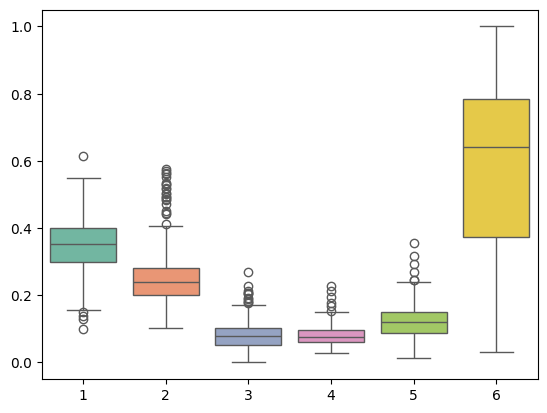

NDVI


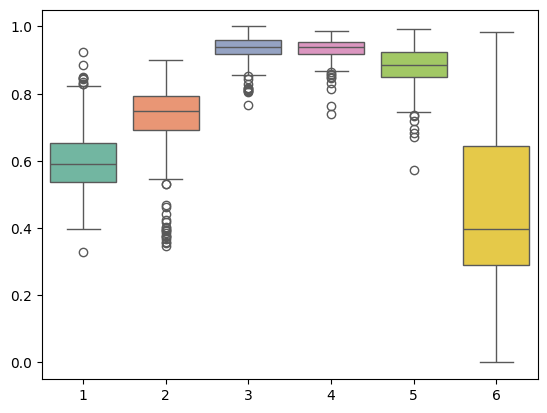

EVI-2


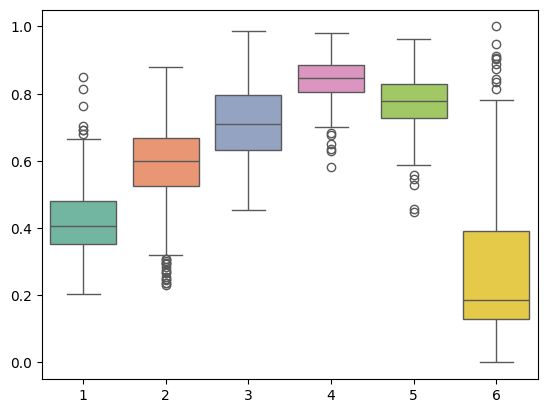

ARVI


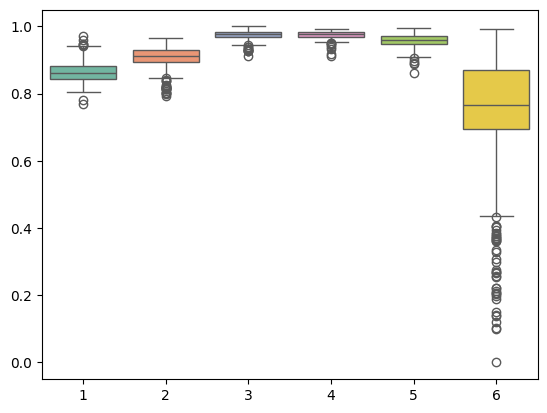

In [ ]:
# Boxplot

#1 : bangunan
#2 : tanah
#3 : hutan
#4 : nonKopi
#5 : kopi
#6 : air
import seaborn as sns
import matplotlib.pyplot as plt
for i in range (11):
  sns.boxplot(x=y_land, y=X_land[...,i], palette="Set2")
  print(band_land[i])
  plt.show()

In [ ]:
# Menghitung rata-rata bands dan index dari setiap label
y_1 = np.where(y_land == 1)[0]
y_2 = np.where(y_land == 2)[0]
y_3 = np.where(y_land == 3)[0]
y_4 = np.where(y_land == 4)[0]
y_5 = np.where(y_land == 5)[0]
y_6 = np.where(y_land == 6)[0]


In [ ]:
mean_bangunan = []
mean_tanah = []
mean_hutan = []
mean_kopi = []
mean_nonKopi = []
mean_air = []

std_bangunan = []
std_tanah = []
std_hutan = []
std_kopi = []
std_nonKopi = []
std_air = []

CI_bangunan = []
CI_tanah = []
CI_hutan = []
CI_kopi = []
CI_nonKopi = []
CI_air = []

max_bangunan = []
max_tanah = []
max_hutan = []
max_kopi = []
max_nonKopi = []
max_air = []

min_bangunan = []
min_tanah = []
min_hutan = []
min_kopi = []
min_nonKopi = []
min_air = []

In [ ]:
for band in range(11):
    bangunan = X_land[y_1, band]
    tanah = X_land[y_2, band]
    hutan = X_land[y_3, band]
    nonKopi = X_land[y_4, band]
    kopi = X_land[y_5, band]
    air = X_land[y_6, band]

    mean_bangunan.append(np.mean(bangunan))
    mean_tanah.append(np.mean(tanah))
    mean_hutan.append(np.mean(hutan))
    mean_kopi.append(np.mean(kopi))
    mean_nonKopi.append(np.mean(nonKopi))
    mean_air.append(np.mean(air))


    std_bangunan.append(np.std(bangunan))
    std_tanah.append(np.std(tanah))
    std_hutan.append(np.std(hutan))
    std_kopi.append(np.std(kopi))
    std_nonKopi.append(np.std(nonKopi))
    std_air.append(np.std(air))


    CI_bangunan.append(st.norm.interval(0.95, loc=np.mean(bangunan), scale=st.sem(bangunan)))
    CI_tanah.append(st.norm.interval(0.95, loc=np.mean(tanah), scale=st.sem(tanah)))
    CI_hutan.append(st.norm.interval(0.95, loc=np.mean(hutan), scale=st.sem(hutan)))
    CI_kopi.append(st.norm.interval(0.95, loc=np.mean(kopi), scale=st.sem(kopi)))
    CI_nonKopi.append(st.norm.interval(0.95, loc=np.mean(nonKopi), scale=st.sem(nonKopi)))
    CI_air.append(st.norm.interval(0.95, loc=np.mean(air), scale=st.sem(air)))


    max_bangunan.append(np.max(bangunan))
    max_tanah.append(np.max(tanah))
    max_hutan.append(np.max(hutan))
    max_kopi.append(np.max(kopi))
    max_nonKopi.append(np.max(nonKopi))
    max_air.append(np.max(air))


    min_bangunan.append(np.min(bangunan))
    min_tanah.append(np.min(tanah))
    min_hutan.append(np.min(hutan))
    min_kopi.append(np.min(kopi))
    min_nonKopi.append(np.min(nonKopi))
    min_air.append(np.min(air))

In [ ]:
mean = pd.DataFrame({'band': band_land,
                     'mean_bangunan' : mean_bangunan,
                     'mean_tanah' : mean_tanah,
                     'mean_hutan' : mean_hutan,
                     'mean_nonKopi' : mean_nonKopi,
                     'mean_kopi' : mean_kopi,
                     'mean_air' : mean_air})

std = pd.DataFrame({'band': band_land,
                    'std_bangunan' : std_bangunan,
                    'std_tanah' : std_tanah,
                    'std_hutan' : std_hutan,
                    'std_nonKopi' : std_nonKopi,
                    'std_kopi' : std_kopi,
                    'std_air' : std_air})

CI = pd.DataFrame({'band': band_land,
                   'CI_bangunan' : CI_bangunan,
                   'CI_tanah' : CI_tanah,
                   'CI_hutan' : CI_hutan,
                   'CI_nonKopi' : CI_nonKopi,
                   'CI_kopi' : CI_kopi,
                   'CI_air' : CI_air})

maximum = pd.DataFrame({'band': band_land,
                        'max_bangunan' : max_bangunan,
                        'max_tanah' : max_tanah,
                        'max_hutan' : max_hutan,
                        'max_nonKopi' : max_nonKopi,
                        'max_kopi' : max_kopi,
                        'max_air' : max_air})

minimum = pd.DataFrame({'band': band_land,
                        'min_bangunan' : min_bangunan,
                        'min_tanah' : min_tanah,
                        'min_hutan' : min_hutan,
                        'min_nonKopi' : min_nonKopi,
                        'min_kopi' : min_kopi,
                        'min_air' : min_air})


In [ ]:
# Informasi Band
# band_land = ["(Blue)B2", "(Green)B3", "(Red)B4", "(NIR)B5", "(SWIR)B6", "(SWIR2)B7","NDBI","NDVI","NDWI","EVI","ARVI","SAVI"]

new_data = pd.DataFrame({'B4': X_land[:,0],
                   'B3': X_land[:,1],
                   'B2': X_land[:,2],
                   'B5': X_land[:,3],
                   'B6': X_land[:,4],
                   'B7': X_land[:,5],
                   'NDBI': X_land[:,6],
                   'NDWI': X_land[:,7],
                   'NDVI': X_land[:,8],
                   'EVI': X_land[:,9],
                   'ARVI': X_land[:,10]})


In [ ]:
new_data

,B4,B3,B2,B5,B6,B7,NDBI,NDWI,NDVI,EVI,ARVI
0,0.290737,0.289255,0.351702,0.427267,0.663655,0.623222,0.870677,0.346483,0.587506,0.387048,0.858993
1,0.290427,0.294194,0.347544,0.442547,0.711694,0.658983,0.893586,0.339092,0.599400,0.401233,0.863703
2,0.256322,0.254312,0.302947,0.436005,0.613294,0.556639,0.810852,0.308492,0.630422,0.418427,0.873764
3,0.313702,0.324774,0.397025,0.467718,0.657244,0.583858,0.813270,0.346188,0.594606,0.408413,0.860672
4,0.287116,0.326826,0.376097,0.527708,0.626618,0.563795,0.714448,0.307852,0.658757,0.479131,0.881961
...,...,...,...,...,...,...,...,...,...,...,...
2053,0.064172,0.138245,0.124755,0.841571,0.430591,0.201202,0.244930,0.043640,0.977140,0.901930,0.991297
2054,0.084921,0.161943,0.153393,0.705735,0.362166,0.184938,0.245929,0.097477,0.932395,0.779995,0.974969
2055,0.074787,0.135111,0.144988,0.606492,0.320098,0.154921,0.259238,0.108597,0.920128,0.706400,0.969516
2056,0.081551,0.176816,0.142732,0.843445,0.405273,0.190109,0.214085,0.070544,0.961126,0.888734,0.985912


In [ ]:
def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

In [ ]:
for i in range(11):
  gvf = goodness_of_variance_fit(new_data.iloc[:, i], 5) # Masukkan banyak kategori yang diinginkan
  print("gvf indeks-",i, ':', gvf)

gvf indeks- 0 : 0.9236132137374793
gvf indeks- 1 : 0.9196937644368457
gvf indeks- 2 : 0.9198055933764898
gvf indeks- 3 : 0.9473803345460219
gvf indeks- 4 : 0.9411308388606179
gvf indeks- 5 : 0.9380193417405498
gvf indeks- 6 : 0.9525608103864052
gvf indeks- 7 : 0.9590826469250069
gvf indeks- 8 : 0.9548981911454723
gvf indeks- 9 : 0.9578915499379138
gvf indeks- 10 : 0.9451301986622005


In [ ]:
df_new = np.array(new_data)
df_new = df_new.flatten('F')

interval = jenkspy.jenks_breaks(df_new, 5)
interval

[0.0, 0.19891965, 0.37462682, 0.5766355, 0.79675514, 1.0]

In [ ]:
pd.DataFrame(std)

,band,std_bangunan,std_tanah,std_hutan,std_nonKopi,std_kopi,std_air
0,(Red)B4,0.075836,0.118550,0.027056,0.030088,0.054452,0.102678
1,(Green)B3,0.077186,0.109403,0.039868,0.039209,0.057560,0.111015
2,(Blue)B2,0.085344,0.106248,0.042337,0.039511,0.058899,0.105126
3,(NIR)B5,0.104445,0.106949,0.135404,0.080446,0.079488,0.198985
4,(SWIR)B6,0.078454,0.158617,0.068942,0.062769,0.080860,0.116231
5,(SWIR2)B7,0.099587,0.150104,0.038000,0.050924,0.072916,0.067971
6,NDBI,0.130575,0.146985,0.040665,0.073017,0.092825,0.097613
7,NDWI,0.082008,0.087430,0.039545,0.028701,0.048283,0.236615
8,NDVI,0.096704,0.106129,0.036478,0.030204,0.056785,0.226448
9,EVI-2,0.106421,0.123682,0.108643,0.061521,0.079538,0.198876


In [ ]:
pd.DataFrame(mean)

,band,mean_bangunan,mean_tanah,mean_hutan,mean_nonKopi,mean_kopi,mean_air
0,(Red)B4,0.310788,0.278831,0.058751,0.106782,0.150439,0.201205
1,(Green)B3,0.334819,0.338123,0.100013,0.178427,0.218693,0.257956
2,(Blue)B2,0.382474,0.352634,0.110250,0.191491,0.228664,0.280196
3,(NIR)B5,0.488256,0.650888,0.604424,0.810661,0.763427,0.258073
4,(SWIR)B6,0.588594,0.534702,0.308114,0.443825,0.531574,0.146061
5,(SWIR2)B7,0.547958,0.375872,0.157764,0.229805,0.316240,0.089870
6,NDBI,0.728187,0.483503,0.242780,0.278503,0.405885,0.266886
7,NDWI,0.345807,0.252914,0.081202,0.080448,0.123123,0.578481
8,NDVI,0.605750,0.727226,0.935809,0.931550,0.880564,0.456601
9,EVI-2,0.427316,0.588866,0.713153,0.842337,0.772077,0.271894


Text(0.5, -29.27777777777778, 'Kelas Target')

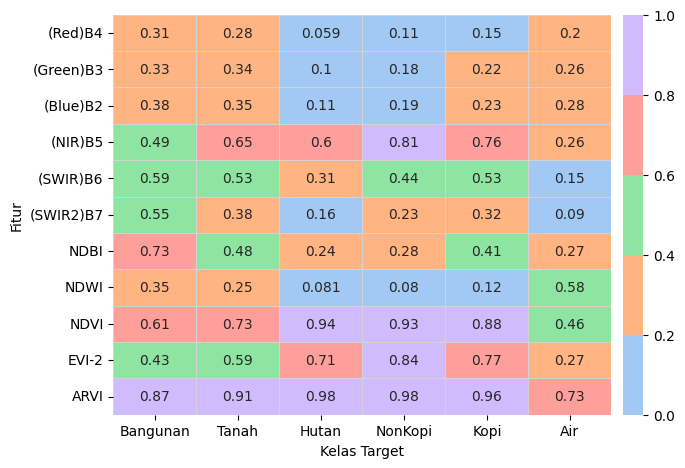

In [ ]:
# use the new color map
fig, ax = plt.subplots(figsize=(8,8))
plt.subplots_adjust(left=0, bottom=0, right=0.75, top=0.5)
cmap = sns.color_palette("pastel", n_colors=5)
sns.heatmap(
    data=mean.iloc[:, 1:],
    xticklabels=["Bangunan","Tanah","Hutan","NonKopi","Kopi","Air"],
    yticklabels=band_land,
    cmap=cmap,
    vmin=0,
    vmax=1,
    linewidths=.5,
    linecolor='lightgray',
    annot=True,
    fmt=".2g",
    cbar_kws={
        'pad': .02,
    },
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0);
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
plt.ylabel('Fitur')
plt.xlabel('Kelas Target')


Visualisasi

In [ ]:
#list of basemap link
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = ('https://server.arcgisonline.com/ArcGIS/rest/services/'
                 'World_Imagery/MapServer/tile/{z}/{y}/{x}'),
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [ ]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    map_vis = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    # basemap used
    basemaps['Google Maps'].add_to(map_vis)
    basemaps['Google Satellite Hybrid'].add_to(map_vis)
    for k,v in dicc.items():
      # check file type before adding to map
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(map_vis)
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(map_vis)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(map_vis)
    map_vis.add_child(folium.LayerControl())
    return map_vis

In [ ]:
# Band Composite Landsat
# Color = [Blue, Green, Red, NIR, SWIR]
# Bands = [B2,   B3,   B4,  B5,   B6]
# Index = [0 ,   1 ,  2 ,   3 ,   4 ]
# satellite images display parameter
vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3,
  'gamma': 1 # gamma boosting 125%
}

# center for location shown by the map
Mapdisplay(center=[center_land.y, center_land.x],
           dicc={'L8':ee.Image("projects/ee-222011520/assets/ujicoba").getMapId(vis_params),
                 'Landsat Training Data':training_land},zoom_start=9)

## Klasifikasi ML

**Pipeline**



In [ ]:
from jcopml.pipeline import num_pipe
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.utils import save_model, load_model
from jcopml.tuning import grid_search_params as gsp
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve,plot_pr_curve
from sklearn.metrics import make_scorer, recall_score, f1_score

In [ ]:
X_land = np.array(X_raw_land)
X_land = np.nan_to_num(X_land, nan=0)
y_land = np.array(y_raw_land)
ndbi_land = normalized_difference(X_land, 4, 3) #(SWIR-NIR)/(SWIR+NIR)
# ndmi_land = normalized_difference(X_land, 3, 4) #(NIR-SWIR)/(NIR+SWIR)
ndvi_land = normalized_difference(X_land, 3, 0) #(NIR-RED)/(NIR+RED)
ndwi_land = normalized_difference(X_land, 1, 3) #(GREEN-NIR)/(GREEN+NIR)
#evi_land  = get_evi(X_land, 3, 0, 2) #2.5*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)
evi2_land = get_evi2(X_land, 3, 0) #2.5*(NIR-RED)/(NIR+2.4*RED+1)
arvi_land = get_arvi(X_land, 3, 0, 2) #(NIR-2*RED-BLUE)/ (NIR+2*RED-BLUE)
# savi_land = get_savi(X_land, 3, 0) #((NIR – RED) / (NIR + RED + 0.5)) * (1.5)
X_land = np.concatenate([X_land, ndbi_land, ndwi_land, ndvi_land, evi2_land, arvi_land], axis=1)
(X_land.shape, y_land.shape)


((2058, 11), (2058,))

In [ ]:
X_land = pd.DataFrame(X_land)
y_land = pd.Series(y_land)
#Data Split
X_train, X_test, y_train, y_test = train_test_split(X_land, y_land, test_size=0.2, stratify=y_land,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1646, 11), (412, 11), (1646,), (412,))

In [ ]:
scoring = {'accuracy': 'accuracy',
           'prec_macro': 'precision_weighted',
           'rec_macro': make_scorer(recall_score, average='weighted'),
           'f1_macro': make_scorer(f1_score, average='weighted')}

def evaluate(X, y, model):
    cv = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring = scoring, cv=cv, n_jobs=-1, verbose=1)
    # print(sorted(scores.keys()))
    print(pd.DataFrame(scores))
    print('Accuracy: %.4f| Precision: %.4f | Recall: %.4f | F1-Score: %.4f' % (np.mean(scores['test_accuracy']), np.mean(scores['test_prec_macro']), np.mean(scores['test_rec_macro']), np.mean(scores['test_f1_macro'])))

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_svm_class_land.pkl', "rb"))


In [ ]:
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.8228155339805825


In [ ]:
model_svm = model
evaluate(X_land, y_land, model_svm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  0.121036    0.043125       0.848397         0.851705        0.848397   
1  0.149103    0.048243       0.833819         0.835844        0.833819   
2  0.134261    0.045571       0.842566         0.846145        0.842566   
3  0.107698    0.045237       0.795918         0.807255        0.795918   
4  0.111794    0.043443       0.839650         0.846032        0.839650   
5  0.071324    0.026877       0.848397         0.849481        0.848397   

   test_f1_macro  
0       0.849150  
1       0.833995  
2       0.843449  
3       0.799927  
4       0.841686  
5       0.848344  
Accuracy: 0.8348| Precision: 0.8394 | Recall: 0.8348 | F1-Score: 0.8361


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.6s finished


In [ ]:
y_pred_test = model_svm.predict(X_test)
accuracy_score(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           1     0.9420    0.9559    0.9489        68
           2     0.7857    0.8088    0.7971        68
           3     0.8194    0.8551    0.8369        69
           4     0.7500    0.7059    0.7273        68
           5     0.6761    0.7164    0.6957        67
           6     0.9697    0.8889    0.9275        72

    accuracy                         0.8228       412
   macro avg     0.8238    0.8218    0.8222       412
weighted avg     0.8256    0.8228    0.8236       412



In [ ]:
# Evaluate the model
print("Model accuracy:", model.score(X_test, y_test))


Model accuracy: 0.8228155339805825


In [ ]:
# Predict using the model
y_pred_test = model.predict(X_test)

In [ ]:
# Print accuracy score and classification report
print("Accuracy Score:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test, digits=4))


Accuracy Score: 0.8228155339805825
Classification Report:
               precision    recall  f1-score   support

           1     0.9420    0.9559    0.9489        68
           2     0.7857    0.8088    0.7971        68
           3     0.8194    0.8551    0.8369        69
           4     0.7500    0.7059    0.7273        68
           5     0.6761    0.7164    0.6957        67
           6     0.9697    0.8889    0.9275        72

    accuracy                         0.8228       412
   macro avg     0.8238    0.8218    0.8222       412
weighted avg     0.8256    0.8228    0.8236       412



Confusion Matrix:
           Bangunan  tanah  hutan  nonKopi  kopi  air
Bangunan        65      2      0        1     0    0
tanah            3     55      0        0     8    2
hutan            0      0     59        8     2    0
nonKopi          0      1      7       48    12    0
kopi             0     10      4        5    48    0
air              1      2      2        2     1   64


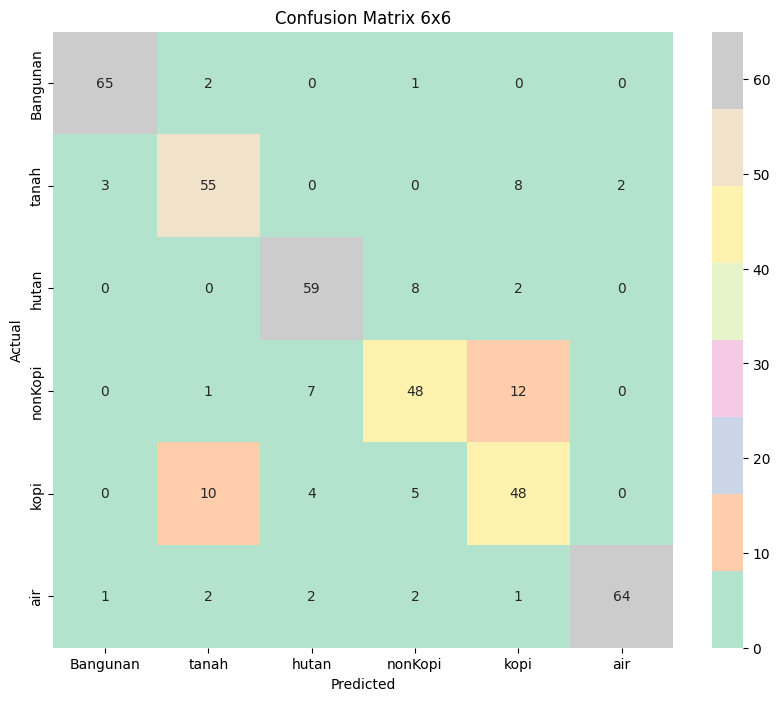

In [79]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Rename classes
class_names = ['Bangunan', 'tanah', 'hutan', 'nonKopi', 'kopi', 'air']

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Print confusion matrix
print("Confusion Matrix:\n", conf_matrix_df)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Pastel2")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 6x6')
plt.show()

In [ ]:
preprocessor = ColumnTransformer([
        ('numeric', num_pipe(scaling='minmax'), X_train.columns)
])

pipeline = Pipeline([
        ('prep', preprocessor),
        ('algo', SVC(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=6, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 6 folds for each of 49 candidates, totalling 294 fits


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         RangeIndex(start=0, stop=11, step=1))])),
                                       ('algo', SVC(max_iter=500))]),
             n_jobs=-1,
             param_grid={'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             verbose=1)

In [ ]:
#Scaling Minmax
print(model.best_params_)
print(model.best_score_, model.score(X_test, y_test))

{'algo__C': 1000.0, 'algo__gamma': 0.1}
0.7995288652952887 0.779126213592233


In [ ]:
#Save Model
pickle.dump(model.best_estimator_,open('/content/drive/MyDrive/Skripsi/code/brovey_svm_class_land.pkl', "wb"))

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_svm_class_land.pkl', "rb"))
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.779126213592233


In [ ]:
model_svm = model
evaluate(X_land, y_land, model_svm)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  0.153061    0.052473       0.801749         0.810532        0.801749   
1  0.145759    0.101891       0.798834         0.805912        0.798834   
2  0.130823    0.075225       0.772595         0.786295        0.772595   
3  0.148655    0.047642       0.778426         0.791024        0.778426   
4  0.125946    0.048455       0.810496         0.821570        0.810496   
5  0.125361    0.033548       0.787172         0.796316        0.787172   

   test_f1_macro  
0       0.804073  
1       0.799163  
2       0.776216  
3       0.776209  
4       0.812853  
5       0.789696  
Accuracy: 0.7915| Precision: 0.8019 | Recall: 0.7915 | F1-Score: 0.7930


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.6s finished


## RandomForest

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_rf_class_land.pkl', "rb"))

In [ ]:
model_rf = model
evaluate(X_land, y_land, model_rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  2.931184    0.070549       0.833819         0.842765        0.833819   
1  2.986154    0.071063       0.825073         0.827171        0.825073   
2  2.946661    0.074937       0.836735         0.839590        0.836735   
3  2.895254    0.083079       0.766764         0.777534        0.766764   
4  3.520478    0.069002       0.825073         0.828630        0.825073   
5  3.356451    0.100492       0.822157         0.822668        0.822157   

   test_f1_macro  
0       0.836561  
1       0.824894  
2       0.837513  
3       0.770549  
4       0.824757  
5       0.821382  
Accuracy: 0.8183| Precision: 0.8231 | Recall: 0.8183 | F1-Score: 0.8193


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    9.7s finished


In [ ]:
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.8155339805825242


In [ ]:
y_pred_test = model_rf.predict(X_test)
accuracy_score(y_test, y_pred_test)
print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           1     0.9231    0.8824    0.9023        68
           2     0.7714    0.7941    0.7826        68
           3     0.8286    0.8406    0.8345        69
           4     0.7429    0.7647    0.7536        68
           5     0.6716    0.6716    0.6716        67
           6     0.9571    0.9306    0.9437        72

    accuracy                         0.8155       412
   macro avg     0.8158    0.8140    0.8147       412
weighted avg     0.8175    0.8155    0.8164       412



In [ ]:
#Pipeline
preprocessor = ColumnTransformer([
        ('numeric', num_pipe(scaling='standard'), X_train.columns)
])

pipeline = Pipeline([
        ('prep', preprocessor),
        ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.rf_params, cv=6, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

Fitting 6 folds for each of 81 candidates, totalling 486 fits


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         RangeIndex(start=0, stop=11, step=1))])),
                                       ('algo',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'algo__max_depth': [20, 50, 80],
                         'algo__max_features': [0.3, 0.6, 0.8],
                         'algo__min_samples_leaf': [1, 5, 10],
                         'algo__n_estimators': [100, 150, 200]},
             verbose=1)

In [ ]:
#Standard
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__max_depth': 20, 'algo__max_features': 0.8, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
1.0 0.7697522671975228 0.7548543689320388


RandomizesearchCV dicoba karena GridsearchCV akan lama menghandle hyperparameter yang banyak, komputasi berat mencoba semua kombinasi

In [ ]:
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
preprocessor = ColumnTransformer([
        ('numeric', num_pipe(), X_train.columns)
])

pipeline = Pipeline([
        ('prep', preprocessor),
        ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=6, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


RandomizedSearchCV(cv=6,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               RangeIndex(start=0, stop=11, step=1))])),
                                             ('algo',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__max_depth': Integer(low=20, high=80),
                                        'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
                                        'algo__min_samples_leaf': Integer(low=1, high=20),
                                        'algo__n_estimators': Integer(low=100, high=200)},
                   random_state=42, verbose=1)

In [ ]:
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

0.9811664641555286 0.7679318734793187 0.7354368932038835


In [ ]:
#Save Model
pickle.dump(model.best_estimator_,open('/content/drive/MyDrive/Skripsi/code/brovey_rf_class_land.pkl', "wb"))

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_rf_class_land.pkl', "rb"))
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.7354368932038835


In [ ]:
model_rf = model
evaluate(X_land, y_land, model_rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  3.080834    0.069890       0.795918         0.799510        0.795918   
1  3.090670    0.069688       0.781341         0.782180        0.781341   
2  3.688867    0.091741       0.781341         0.792643        0.781341   
3  3.479212    0.111203       0.749271         0.755035        0.749271   
4  5.221312    0.140562       0.755102         0.763957        0.755102   
5  5.425345    0.069327       0.766764         0.779358        0.766764   

   test_f1_macro  
0       0.796546  
1       0.781482  
2       0.784914  
3       0.748675  
4       0.758665  
5       0.770767  
Accuracy: 0.7716| Precision: 0.7788 | Recall: 0.7716 | F1-Score: 0.7735


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.5s finished


## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_XGBoost_class_best.pkl', "rb"))

In [ ]:
model_xg = model
evaluate(X_land, y_land_adjusted, model_xg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  1.260373    0.032721       0.816327         0.823330        0.816327   
1  0.904835    0.033433       0.833819         0.835164        0.833819   
2  1.172269    0.043869       0.839650         0.842096        0.839650   
3  0.984388    0.044230       0.758017         0.766460        0.758017   
4  1.137773    0.041616       0.825073         0.829736        0.825073   
5  1.055520    0.027122       0.807580         0.810631        0.807580   

   test_f1_macro  
0       0.818932  
1       0.834085  
2       0.840308  
3       0.760655  
4       0.823698  
5       0.808652  
Accuracy: 0.8134| Precision: 0.8179 | Recall: 0.8134 | F1-Score: 0.8144


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.5s finished


In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_XGBoost_class_best.pkl', "rb"))
model.fit(X_train,y_train_adjusted)
print(model.score(X_test, y_test_adjusted))

0.8131067961165048


In [ ]:
model_xg = model
evaluate(X_land, y_land_adjusted, model_xg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  0.656593    0.031532       0.816327         0.823330        0.816327   
1  0.640645    0.037736       0.833819         0.835164        0.833819   
2  0.632376    0.017753       0.839650         0.842096        0.839650   
3  0.630840    0.018425       0.758017         0.766460        0.758017   
4  0.644647    0.015458       0.825073         0.829736        0.825073   
5  0.628184    0.018470       0.807580         0.810631        0.807580   

   test_f1_macro  
0       0.818932  
1       0.834085  
2       0.840308  
3       0.760655  
4       0.823698  
5       0.808652  
Accuracy: 0.8134| Precision: 0.8179 | Recall: 0.8134 | F1-Score: 0.8144


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.0s finished


In [ ]:
y_pred_test = model_xg.predict(X_test)
accuracy_score(y_test_adjusted, y_pred_test)
print(classification_report(y_test_adjusted, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     0.8955    0.8824    0.8889        68
           1     0.6667    0.6176    0.6412        68
           2     0.7857    0.7971    0.7914        69
           3     0.6857    0.7059    0.6957        68
           4     0.5493    0.5821    0.5652        67
           5     0.9155    0.9028    0.9091        72

    accuracy                         0.7500       412
   macro avg     0.7497    0.7480    0.7486       412
weighted avg     0.7519    0.7500    0.7507       412



In [ ]:
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
y_land_adjusted = y_land - 1

preprocessor = ColumnTransformer([
        ('numeric', num_pipe(scaling='standard'), X_train.columns)
])

pipeline = Pipeline([
        ('prep', preprocessor),
        ('algo', XGBClassifier())
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params,n_iter=50, cv=6, n_jobs=-1, verbose=1)
model.fit(X_train, y_train_adjusted)

NameError: name 'RandomizedSearchCV' is not defined

In [ ]:
# #Save Model
pickle.dump(model.best_estimator_,open('/content/drive/MyDrive/Skripsi/code/brovey_XGBoost_class_best.pkl', "wb"))

In [ ]:

model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_XGBoost_class_best.pkl', "rb"))
model.fit(X_train,y_train_adjusted)

print(model.score(X_train, y_train_adjusted), model.score(X_test, y_test_adjusted))

0.9395833333333333 0.8416666666666667


In [ ]:


plot_classification_report(X_train, y_train_adjusted, X_test, y_test_adjusted, model, report=True)

Train report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       240
           1       0.93      0.93      0.93       240
           2       0.94      0.95      0.94       240
           3       0.92      0.93      0.92       240
           4       0.89      0.90      0.90       240
           5       0.98      0.96      0.97       240

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440


Test report
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        60
           1       0.80      0.73      0.77        60
           2       0.96      0.82      0.88        60
           3       0.75      0.85      0.80        60
           4       0.80      0.80      0.80        60
           5       0.92      0.92      0.92        60

    accuracy                           0.84       3

In [ ]:


model = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_XGBoost_class_best.pkl', "rb"))
model_xg = model
evaluate(X_land, y_land_adjusted, model_xg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


   fit_time  score_time  test_accuracy  test_prec_macro  test_rec_macro  \
0  0.941344    0.019056       0.823333         0.826314        0.823333   
1  0.976362    0.022495       0.836667         0.837671        0.836667   
2  1.211110    0.056149       0.796667         0.802605        0.796667   
3  1.050826    0.051125       0.796667         0.805919        0.796667   
4  2.008916    0.043824       0.820000         0.824059        0.820000   
5  1.755918    0.072785       0.810000         0.820680        0.810000   

   test_f1_macro  
0       0.823956  
1       0.836576  
2       0.798130  
3       0.799262  
4       0.819566  
5       0.812479  
Accuracy: 0.8139| Precision: 0.8195 | Recall: 0.8139 | F1-Score: 0.8150


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.2s finished


# Deep Learning

In [ ]:
X_land = np.array(X_raw_land)
X_land = np.nan_to_num(X_land, nan=0)
y_land = np.array(y_raw_land)
ndbi_land = normalized_difference(X_land, 4, 3) #(SWIR-NIR)/(SWIR+NIR)
# ndmi_land = normalized_difference(X_land, 3, 4) #(NIR-SWIR)/(NIR+SWIR)
ndvi_land = normalized_difference(X_land, 3, 0) #(NIR-RED)/(NIR+RED)
ndwi_land = normalized_difference(X_land, 1, 3) #(GREEN-NIR)/(GREEN+NIR)
#evi_land  = get_evi(X_land, 3, 0, 2) #2.5*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)
evi2_land = get_evi2(X_land, 3, 0) #2.5*(NIR-RED)/(NIR+2.4*RED+1)
arvi_land = get_arvi(X_land, 3, 0, 2) #(NIR-2*RED-BLUE)/ (NIR+2*RED-BLUE)
# savi_land = get_savi(X_land, 3, 0) #((NIR – RED) / (NIR + RED + 0.5)) * (1.5)
X_land = np.concatenate([X_land, ndbi_land, ndwi_land, ndvi_land, evi2_land, arvi_land], axis=1)
X_land = pd.DataFrame(X_land)
(X_land.shape, y_land.shape)

((2058, 11), (2058,))

In [ ]:
y_land = np.where(y_land==1, 0, y_land)
y_land = np.where(y_land==2, 1, y_land)
y_land = np.where(y_land==3, 2, y_land)
y_land = np.where(y_land==4, 3, y_land)
y_land = np.where(y_land==5, 4, y_land)
y_land = np.where(y_land==6, 5, y_land)
y_land = np.where(y_land==7, 6, y_land)

In [ ]:
#Data Split
X_train, X_test, y_train, y_test = train_test_split(X_land, y_land, test_size=0.2, stratify=y_land,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

preprocessor = ColumnTransformer([
        ('numeric', num_pipe(), X_train.columns)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Tensor

### Dataset & DataLoader

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim

In [ ]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


In [ ]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

### Training Preparation -> MCO

In [ ]:
model = nn.Sequential(
    nn.Linear(11, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 6),
    nn.LogSoftmax(1),
)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

#### Training

In [ ]:
epochs = 200
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader:
        output = model(feature) #feedfoward
        loss = criterion(output, target)
        loss.backward() #backprop

        optimizer.step() #update weigth
        optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))

    with torch.no_grad():
        model.eval()
        cost = 0
        for feature, target in testloader:
            output = model(feature) #feedfoward
            loss = criterion(output, target)

            cost += loss.item() * feature.shape[0]
        test_cost.append(cost / len(test_set))

    print(f"\rEpoch: {i+1:4}/{epochs:4} | train_cost: {train_cost[-1]:4f} | test_cost: {test_cost[-1]:4f}", end = " ")

Epoch:  200/ 200 | train_cost: 0.600114 | test_cost: 0.630334 

In [ ]:
import matplotlib.pyplot as plt

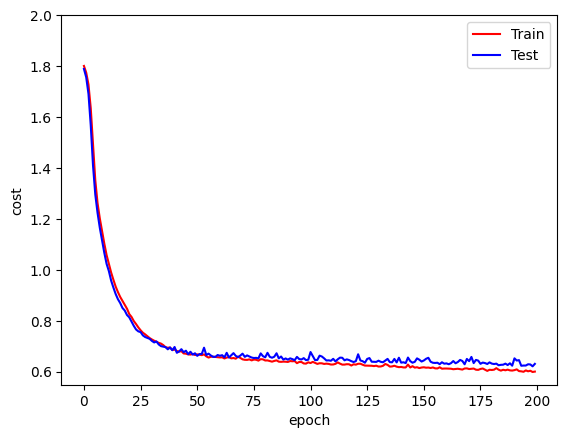

In [ ]:
plt.plot(train_cost, 'r-', label="Train")
plt.plot(test_cost, 'b-', label="Test")
ax = plt.gca()
ax.set_ylim([min(train_cost)-0.05, 2])
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend()

In [ ]:
with torch.no_grad():
        model.eval()
        output = model(X_test)

In [ ]:
pred = output.argmax(1)
pred

tensor([3, 2, 5, 5, 5, 2, 2, 4, 3, 1, 1, 5, 3, 5, 3, 2, 1, 5, 0, 1, 1, 5, 2, 5,
        5, 0, 1, 0, 4, 2, 4, 2, 2, 0, 3, 4, 2, 0, 2, 5, 5, 0, 3, 2, 2, 0, 3, 0,
        3, 5, 3, 3, 2, 5, 0, 2, 0, 0, 4, 3, 2, 1, 3, 0, 0, 0, 5, 0, 0, 3, 3, 3,
        1, 4, 4, 0, 5, 4, 3, 5, 1, 1, 3, 4, 2, 4, 4, 1, 1, 2, 5, 2, 5, 3, 2, 3,
        5, 3, 0, 2, 0, 4, 3, 5, 0, 3, 0, 0, 5, 2, 4, 3, 3, 3, 4, 4, 3, 3, 3, 5,
        4, 4, 0, 4, 1, 0, 4, 1, 0, 3, 1, 2, 4, 0, 3, 1, 2, 1, 1, 3, 5, 2, 0, 1,
        3, 2, 4, 0, 3, 5, 1, 1, 3, 5, 1, 5, 4, 2, 4, 4, 4, 1, 5, 5, 1, 1, 5, 2,
        2, 3, 0, 5, 5, 3, 3, 1, 0, 0, 1, 3, 2, 5, 3, 3, 4, 5, 3, 2, 1, 4, 3, 1,
        4, 5, 2, 4, 1, 0, 5, 4, 5, 0, 3, 1, 5, 4, 5, 1, 2, 1, 5, 0, 3, 2, 3, 0,
        4, 2, 4, 4, 5, 0, 3, 4, 5, 5, 0, 0, 2, 1, 3, 0, 5, 3, 1, 5, 1, 0, 1, 2,
        4, 1, 4, 5, 3, 3, 4, 4, 0, 5, 4, 2, 2, 5, 0, 1, 2, 4, 1, 5, 1, 3, 2, 1,
        0, 4, 5, 5, 2, 3, 0, 2, 4, 2, 4, 0, 0, 5, 3, 5, 2, 3, 4, 1, 0, 0, 2, 0,
        5, 4, 5, 4, 5, 4, 1, 0, 0, 4, 3,

In [ ]:
(y_test == pred)

tensor([ True, False,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False, False,  True,
         True,  True,  True, False, False,  True, False,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True, False, False,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
        False, False,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, 

### ACC

In [ ]:
acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.7694)

### Training

In [ ]:
 model = nn.Sequential(
    nn.Linear(11, 64),
    nn.ReLU(),
    nn.Dropout(0.25),

    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(32, 16),
    nn.ReLU(),

    nn.Linear(16, 8),
    nn.ReLU(),

    nn.Linear(8, 7),
    nn.LogSoftmax(1),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
  if mode == "train":
    model.train()
  elif mode == "test":
    model.eval()
  cost = correct = 0
  for feature, target in dataloader:
        output = model(feature) #feedfoward
        loss = criterion(output, target)

        if mode =="train":
          loss.backward() #backprop
          optimizer.step() #update weigth
          optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
  cost = cost / len(dataset)
  acc = correct / len(dataset)
  return cost, acc

In [ ]:
epochs = 1000
train_cost, test_cost = [], []
train_acc, test_acc = [], []
for i in range(epochs) :
    cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad():
      cost, acc = loop_fn("test", test_set, testloader, model, criterion, optimizer)
      test_cost.append(cost)
      test_acc.append(acc)
    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:4f} | test_cost: {test_cost[-1]:4f} | "
          f"train_acc: {train_acc[-1]:4f} | test_acc: {test_acc[-1]:4f}", end = " ")

Epoch: 1000/1000 | train_cost: 0.478756 | test_cost: 0.520050 | train_acc: 0.814095 | test_acc: 0.822816 

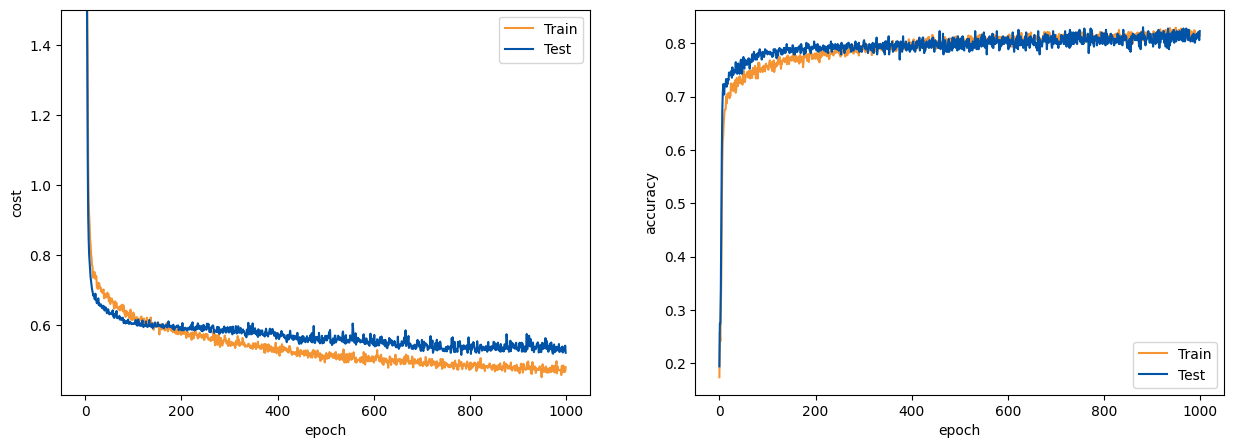

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(train_cost, '#f59433', label="Train")
plt.plot(test_cost, '#0053a6', label="Test")
ax = plt.gca()
ax.set_ylim([min(train_cost)-0.05, 1.5])
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend()

plt.subplot(122)
plt.plot(train_acc, '#f59433', label="Train")
plt.plot(test_acc, '#0053a6', label="Test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend()

## Deep Learning

In [ ]:
X_land = np.array(X_raw_land)
X_land = np.nan_to_num(X_land, nan=0)
y_land = np.array(y_raw_land)
ndbi_land = normalized_difference(X_land, 4, 3) #(SWIR-NIR)/(SWIR+NIR)
ndmi_land = normalized_difference(X_land, 3, 4) #(NIR-SWIR)/(NIR+SWIR)
ndvi_land = normalized_difference(X_land, 3, 0) #(NIR-RED)/(NIR+RED)
#evi_land  = get_evi(X_land, 3, 0, 2) #2.5*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)
evi2_land = get_evi2(X_land, 3, 0) #2.5*(NIR-RED)/(NIR+2.4*RED+1)
arvi_land = get_arvi(X_land, 3, 0, 2) #(NIR-2*RED-BLUE)/ (NIR+2*RED-BLUE)
X_land = np.concatenate([X_land, ndbi_land, ndmi_land, ndvi_land, evi2_land, arvi_land], axis=1)
X_land.shape,y_land.shape

((2058, 11), (2058,))

In [ ]:
X_land_n = X_land.reshape((X_land.shape[0], 1, X_land.shape[1]))

In [ ]:
y_land = np.where(y_land==1, 0, y_land)
y_land = np.where(y_land==2, 1, y_land)
y_land = np.where(y_land==3, 2, y_land)
y_land = np.where(y_land==4, 3, y_land)
y_land = np.where(y_land==5, 4, y_land)
y_land = np.where(y_land==6, 5, y_land)
y_land = np.where(y_land==7, 6, y_land)
# y_land_n = to_categorical(y_land)

In [ ]:
y_land_n = to_categorical(y_land)
X_train, X_test, y_train, y_test = train_test_split(X_land_n, y_land_n, test_size=0.2, stratify=y_land,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1646, 1, 11), (412, 1, 11), (1646, 6), (412, 6))

In [ ]:
def get_mlp(input_data):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_data.shape[1:]),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

    return model

In [ ]:
def evaluate_model(MODEL, trainX, trainy, testX, testy):
	# encode targets
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	# define model
	model = MODEL
	# fit model
	model.fit(trainX, trainy_enc, epochs=300, batch_size=64, verbose=1)
	# evaluate the model
	_, acc, pre, rec = model.evaluate(testX, testy_enc, batch_size=64, verbose=1)
	return model, acc, pre, rec

In [ ]:
X = X_land_n
y = y_land
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X,y):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_mlp(input_data=X),
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc,
          'precision : >%.3f' % pre,
          'recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/300
39/39 [==============================] - 2s 4ms/step - loss: 1.6574 - accuracy: 0.3285 - precision: 1.0000 - recall: 0.0144
Epoch 2/300
39/39 [==============================] - 0s 4ms/step - loss: 1.1267 - accuracy: 0.5312 - precision: 0.9132 - recall: 0.2107
Epoch 3/300
39/39 [==============================] - 0s 3ms/step - loss: 0.8366 - accuracy: 0.6763 - precision: 0.7985 - recall: 0.4367
Epoch 4/300
39/39 [==============================] - 0s 3ms/step - loss: 0.7052 - accuracy: 0.7135 - precision: 0.7835 - recall: 0.6146
Epoch 5/300
39/39 [==============================] - 0s 4ms/step - loss: 0.6740 - accuracy: 0.7344 - precision: 0.7662 - recall: 0.6815
Epoch 6/300
39/39 [==============================] - 0s 3ms/step - loss: 0.6413 - accuracy: 0.7492 - precision: 0.7748 - recall: 0.6947
Epoch 7/300
39/39 [==============================] - 0s 3ms/step - loss: 0.6268 - accuracy: 0.7452 - precision: 0.7752 - recall: 0.7047
Epoch 8/300
39/39 [=============================

In [ ]:
df_land_mlp = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_land_mlp['f1'] = (2*(df_land_mlp['precision']*df_land_mlp['recall'])/
                      (df_land_mlp['precision']+df_land_mlp['recall']))
df_land_mlp

,accuracy,precision,recall,f1
0,0.802885,0.819237,0.791667,0.805216
1,0.814103,0.832496,0.796474,0.814087
2,0.834936,0.857877,0.802885,0.829470
3,0.823718,0.836093,0.809295,0.822476
4,0.798077,0.815920,0.788462,0.801956


In [ ]:
print('accuracy : %.4f' % np.mean(df_land_mlp['accuracy']),
      'precision : %.4f' % np.mean(df_land_mlp['precision']),
      '; recall : %.4f' % np.mean(df_land_mlp['recall']),
      '; f1-score : %.4f' % np.mean(df_land_mlp['f1']))

accuracy : 0.8147 precision : 0.8323 ; recall : 0.7978 ; f1-score : 0.8146


In [ ]:
model_mlp_land = get_mlp(input_data=X_land_n)
model_mlp_land.fit(
    x=X_train,
    y=y_train,
    epochs=300,
    validation_data=(X_test, y_test),
    batch_size=64)
model_mlp_land.save('/content/drive/MyDrive/Skripsi/code/mlp_model_land.h5')

Epoch 1/300
39/39 [==============================] - 2s 12ms/step - loss: 1.5592 - accuracy: 0.5028 - precision: 1.0000 - recall: 0.0401 - val_loss: 1.1816 - val_accuracy: 0.5657 - val_precision: 0.9833 - val_recall: 0.1891
Epoch 2/300
39/39 [==============================] - 0s 5ms/step - loss: 0.9435 - accuracy: 0.6174 - precision: 0.8286 - recall: 0.3409 - val_loss: 0.8476 - val_accuracy: 0.6346 - val_precision: 0.7673 - val_recall: 0.4808
Epoch 3/300
39/39 [==============================] - 0s 4ms/step - loss: 0.7631 - accuracy: 0.6967 - precision: 0.7699 - recall: 0.5509 - val_loss: 0.7066 - val_accuracy: 0.7228 - val_precision: 0.7765 - val_recall: 0.6571
Epoch 4/300
39/39 [==============================] - 0s 4ms/step - loss: 0.6851 - accuracy: 0.7272 - precision: 0.7692 - recall: 0.6462 - val_loss: 0.6412 - val_accuracy: 0.7308 - val_precision: 0.7641 - val_recall: 0.6747
Epoch 5/300
39/39 [==============================] - 0s 4ms/step - loss: 0.6441 - accuracy: 0.7468 - precis

In [ ]:
load_model = keras.models.load_model('/content/drive/MyDrive/Skripsi/code/mlp_model_land.h5')
loss, acc , prec, rec= load_model.evaluate(X_test, y_test)
print("Acc : {:.4f}".format(acc),"Prec : {:.4f}".format(prec),"| Rec : {:.4f}".format(rec),"| F1-score : {:.4f}".format(2*prec*rec/(prec+rec)))

20/20 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.8253 - precision: 0.8383 - recall: 0.8061
Acc : 0.8253 Prec : 0.8383 | Rec : 0.8061 | F1-score : 0.8219


In [ ]:
def get_cnn(input_data):
    model = keras.Sequential([
        keras.layers.InputLayer(input_data.shape[1:]),
        keras.layers.Conv1D(filters=32, kernel_size=1,
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Conv1D(filters=32, kernel_size=1,
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Conv1D(filters=64, kernel_size=1,
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Conv1D(filters=64, kernel_size=1,
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

    return model

In [ ]:
X = X_land_n
y = y_land
n_folds = 5
kfold = StratifiedKFold(n_folds, shuffle=True, random_state=42)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X,y):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_cnn(input_data=X),
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc,
          'precision : >%.3f' % pre,
          'recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/300
26/26 [==============================] - 2s 4ms/step - loss: 1.6737 - accuracy: 0.3123 - precision: 1.0000 - recall: 0.0018    
Epoch 2/300
26/26 [==============================] - 0s 5ms/step - loss: 1.1719 - accuracy: 0.5018 - precision: 0.8639 - recall: 0.1543
Epoch 3/300
26/26 [==============================] - 0s 5ms/step - loss: 0.8619 - accuracy: 0.6458 - precision: 0.7419 - recall: 0.4453
Epoch 4/300
26/26 [==============================] - 0s 5ms/step - loss: 0.7571 - accuracy: 0.7017 - precision: 0.7549 - recall: 0.6136
Epoch 5/300
26/26 [==============================] - 0s 4ms/step - loss: 0.7183 - accuracy: 0.7309 - precision: 0.7769 - recall: 0.6622
Epoch 6/300
26/26 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.7357 - precision: 0.7839 - recall: 0.6677
Epoch 7/300
26/26 [==============================] - 0s 5ms/step - loss: 0.7029 - accuracy: 0.7163 - precision: 0.7519 - recall: 0.6683
Epoch 8/300
26/26 [=========================

In [ ]:
df_land_cnn = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_land_cnn['f1'] = (2*(df_land_cnn['precision']*df_land_cnn['recall'])/
                      (df_land_cnn['precision']+df_land_cnn['recall']))
df_land_cnn

,accuracy,precision,recall,f1
0,0.817961,0.822335,0.786408,0.803970
1,0.796117,0.817010,0.769417,0.792500
2,0.779126,0.793532,0.774272,0.783784
3,0.795620,0.829787,0.759124,0.792884
4,0.810219,0.823980,0.785888,0.804483


In [ ]:
print('accuracy : %.4f' % np.mean(df_land_cnn['accuracy']),
      'precision : %.4f' % np.mean(df_land_cnn['precision']),
      '; recall : %.4f' % np.mean(df_land_cnn['recall']),
      '; f1-score : %.4f' % np.mean(df_land_cnn['f1']))

accuracy : 0.7998 precision : 0.8173 ; recall : 0.7750 ; f1-score : 0.7955


In [ ]:
model_cnn_land = get_cnn(input_data=X_land_n)
model_cnn_land.fit(
    x=X_train,
    y=y_train,
    epochs=300,
    validation_data=(X_test, y_test),
    batch_size=64)
model_cnn_land.save('/content/drive/MyDrive/Skripsi/code/cnn_model_land.h5')

Epoch 1/300
26/26 [==============================] - 3s 22ms/step - loss: 1.6604 - accuracy: 0.4927 - precision: 1.0000 - recall: 0.0182 - val_loss: 1.3065 - val_accuracy: 0.5898 - val_precision: 1.0000 - val_recall: 0.0922
Epoch 2/300
26/26 [==============================] - 0s 6ms/step - loss: 0.9788 - accuracy: 0.6233 - precision: 0.7935 - recall: 0.3572 - val_loss: 0.7339 - val_accuracy: 0.7209 - val_precision: 0.7791 - val_recall: 0.6165
Epoch 3/300
26/26 [==============================] - 0s 6ms/step - loss: 0.7605 - accuracy: 0.6944 - precision: 0.7348 - recall: 0.6160 - val_loss: 0.8102 - val_accuracy: 0.6772 - val_precision: 0.6943 - val_recall: 0.5898
Epoch 4/300
26/26 [==============================] - 0s 7ms/step - loss: 0.6974 - accuracy: 0.7230 - precision: 0.7517 - recall: 0.6586 - val_loss: 0.6519 - val_accuracy: 0.7549 - val_precision: 0.7715 - val_recall: 0.6966
Epoch 5/300
26/26 [==============================] - 0s 6ms/step - loss: 0.6659 - accuracy: 0.7236 - precis

In [ ]:
load_model = keras.models.load_model('/content/drive/MyDrive/Skripsi/code/cnn_model_land.h5')
loss, acc , prec, rec= load_model.evaluate(X_test, y_test)
print("Acc : {:.4f}".format(acc),"Prec : {:.4f}".format(prec),"| Rec : {:.4f}".format(rec),"| F1-score : {:.4f}".format(2*prec*rec/(prec+rec)))

13/13 [==============================] - 0s 3ms/step - loss: 0.6139 - accuracy: 0.7985 - precision: 0.8226 - recall: 0.7767
Acc : 0.7985 Prec : 0.8226 | Rec : 0.7767 | F1-score : 0.7990


# Viz Map Class

In [ ]:
model_svm = pickle.load(open('/content/drive/MyDrive/Skripsi/code/brovey_svm_class_land.pkl', "rb"))

In [ ]:
#Kecamatan mekakau ilir
out = "/content/drive/MyDrive/Data-Satelit"
path_land = os.path.join(out, 'Landsat-8-sungai_are-2022-IHS')
raster_land = ".".join([path_land, "tif"])
new_image_land = raster_land
output_image_land = os.path.join(data,'Landsat-30-cliped-rf.tif')

In [ ]:
from numpy.lib.function_base import append
def write_raster(input_image, output_image, classifier):
    with rasterio.open(input_image, 'r') as src:
        profile = src.profile
        profile.update(
            dtype=rasterio.uint8,
            count=1,
        )
        with rasterio.open(output_image, 'w', **profile) as dst:

            patch_size = 500

            for i in range((src.shape[0] // patch_size) + 1):
                for j in range((src.shape[1] // patch_size) + 1):
                    window = rasterio.windows.Window(
                        j * patch_size,
                        i * patch_size,
                        min(patch_size, src.shape[1] - j * patch_size),
                        min(patch_size, src.shape[0] - i * patch_size))

                    data = src.read(window=window)

                    img_swp = np.moveaxis(data, 0, 2)
                    img_flat = img_swp.reshape(-1, img_swp.shape[-1])
                    img_ndbi = normalized_difference(img_flat, 4, 3) #(SWIR-NIR)/(SWIR+NIR)
                    img_ndwi = normalized_difference(img_flat, 1, 3) #(GREEN-NIR)/(GREEN+NIR)
                    img_ndvi = normalized_difference(img_flat, 3, 0) #(NIR-RED)/(NIR+RED)
                    img_evi = get_evi2(img_flat, 3, 0) #2.5*(NIR-RED)/(NIR+2.4*RED+1)
                    img_arvi = get_arvi(img_flat, 3, 0, 2) #(NIR-2*RED-BLUE)/ (NIR+2*RED-BLUE)

                    img_w_ind = np.concatenate([img_flat,img_ndbi, img_ndwi, img_ndvi, img_evi, img_arvi], axis=1)
                    m = np.ma.masked_invalid(img_w_ind)
                    print(img_w_ind[~m.mask].shape)
                    to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])
                    print(to_predict.shape)

                    if not len(to_predict):
                        continue
                    img_preds = classifier.predict(to_predict)

                    output = np.zeros(img_flat.shape[0])
                    output[~m.mask[:, 0]] = img_preds.flatten()
                    output = output.reshape(*img_swp.shape[:-1])

                    mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                    dst.write(output.astype(rasterio.uint8), 1, window=window)
                    dst.write_mask(mask, window=window)

In [ ]:
write_raster(new_image_land, output_image_land, model_svm)

(1675102,)
(152282, 11)
(35651,)
(3241, 11)
(459547,)
(41777, 11)
(1133,)
(103, 11)


In [ ]:
def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / float(imax - imin)
    return image * (omax - omin) + omin

# load original image
with rasterio.open(new_image_land, 'r') as raster:
  l8_30 = raster.read([3,2,1])
  for band in range(l8_30.shape[0]):
    l8_30[band] = linear_rescale(
            l8_30[band],
            in_range=(0, 3000),
            out_range=[0, 255]
        )
  l8_30 = l8_30.astype(np.uint8)

with rasterio.open(output_image_land, 'r') as svm_class_raster:
#  Tampilkan peta class_raster
  svm_classes_land = svm_class_raster.read()

<Axes: title={'center': 'SVM Classes Landsat-8'}>

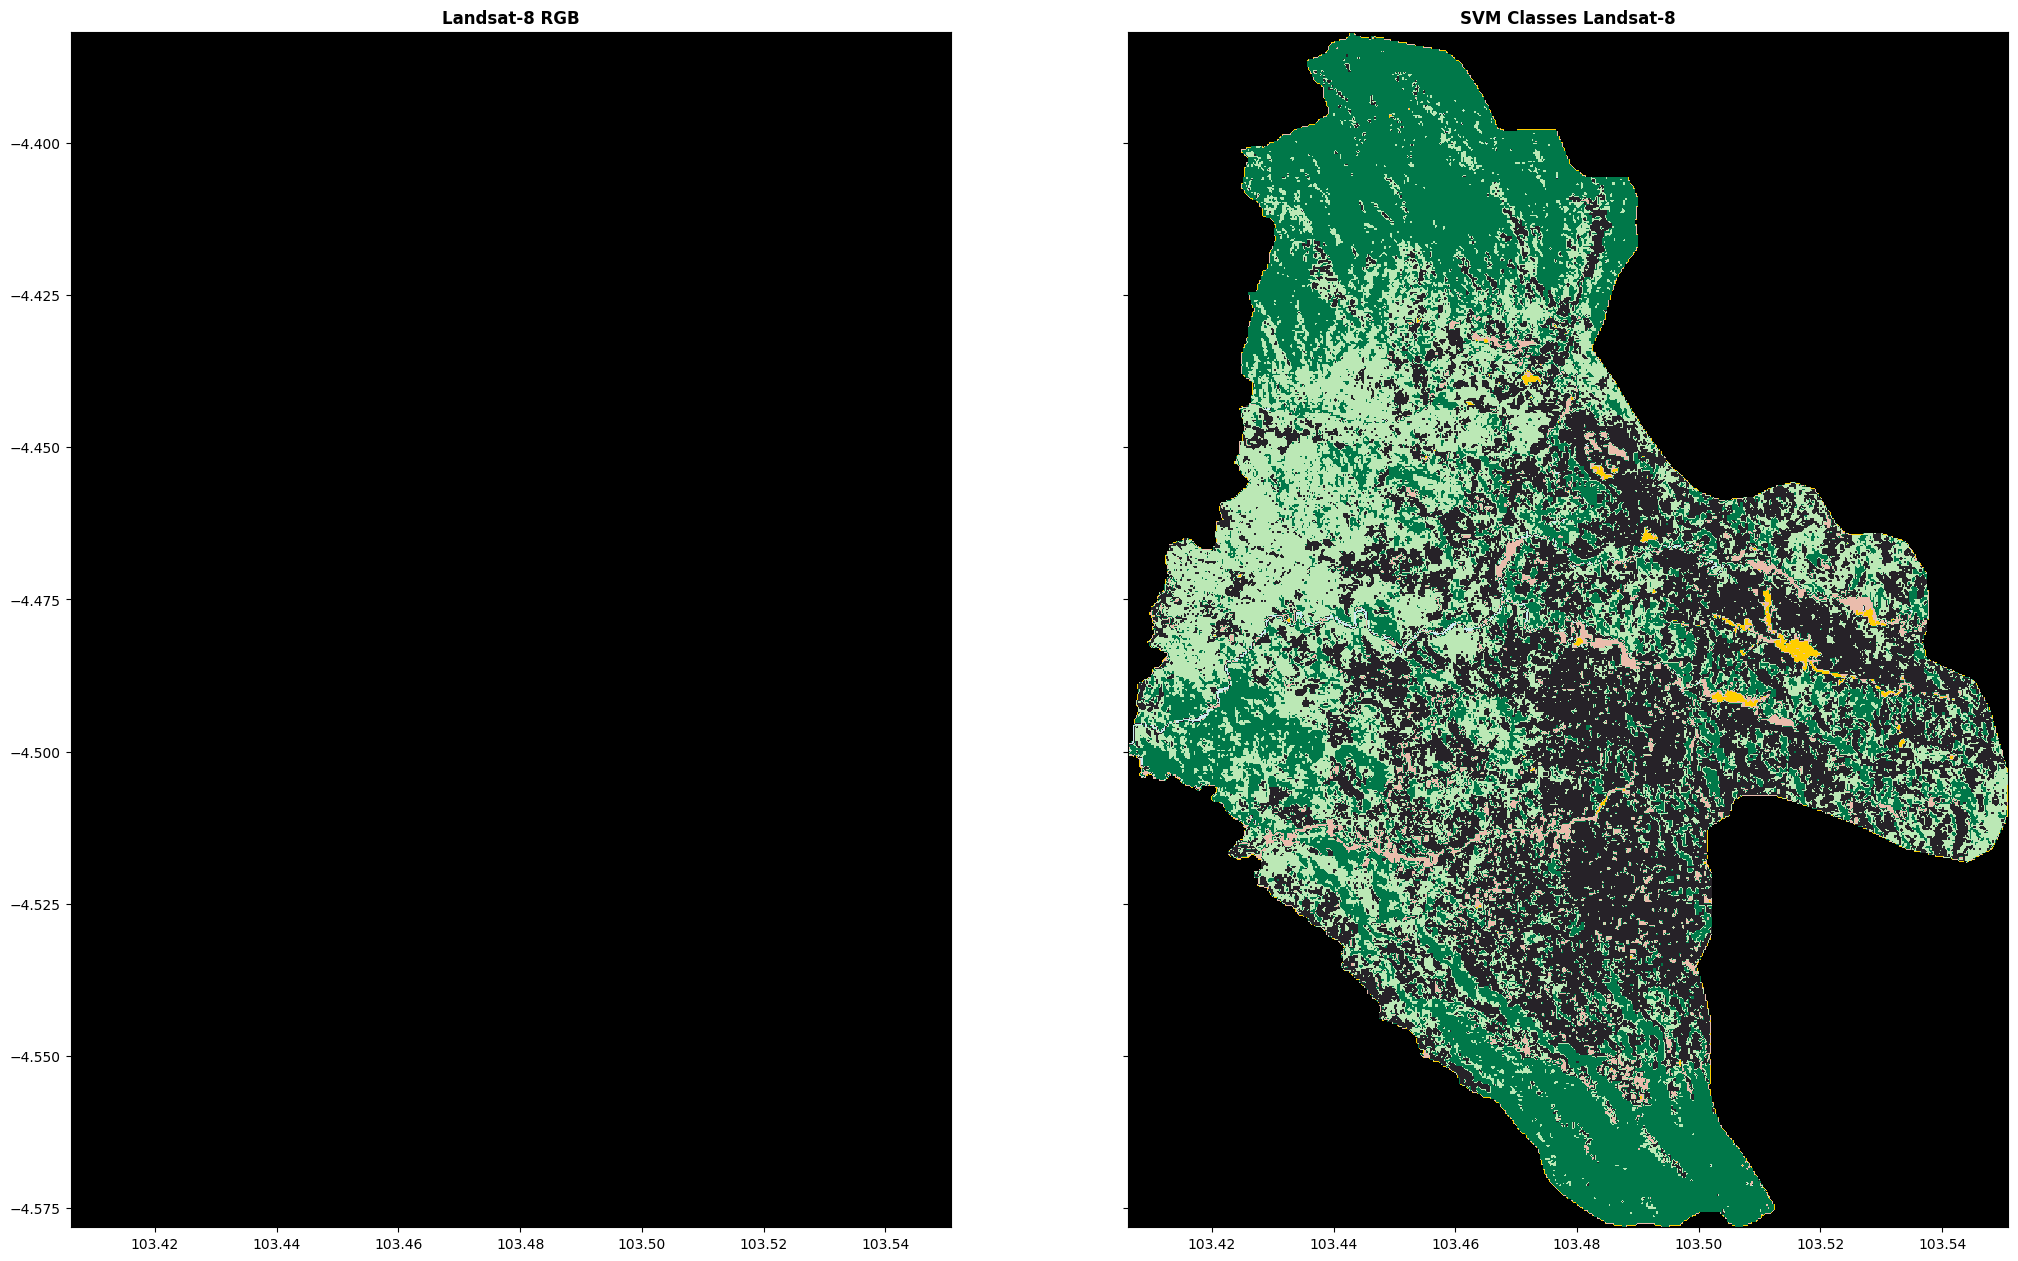

In [ ]:
#0 : none #1 : bangunan #2 : tanah #3 : hutan #4 : nonKopi #5 : kopi #6 : air
cls_colors = ["#000000", '#FFCE00', '#EABCAC', '#007849', '#BBE8B5', '#262228','#CAEBF2']
clr_land = colors.ListedColormap([colors.hex2color(x) for x in cls_colors])

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(25, 25), sharey=True)

show(l8_30[[2,1,0], : , :], transform=raster.transform, adjust='linear', ax=ax1, title="Landsat-8 RGB")

show(svm_classes_land,
     transform=svm_class_raster.transform,
     ax=ax2,
     title="SVM Classes Landsat-8",
     cmap = clr_land)

In [ ]:
file = output_image_land

# Open the image and read in the values as an array
dataset = gdal.Open(file)
band = dataset.GetRasterBand(1)
Cols = dataset.RasterXSize
Rows = dataset.RasterYSize
arr = band.ReadAsArray(0, 0, Cols, Rows).astype(float)

# subset the array to only contain classification values equal to ...
class0 = arr[arr==0] #none
class1 = arr[arr==1] #bangunan
class2 = arr[arr==2] #tanah
class3 = arr[arr==3] #hutan
class4 = arr[arr==4] #nonKopi
class5 = arr[arr==5] #kopi
class6 = arr[arr==6] #air

pixel_area = 0.3 * 0.3  # 30 meter per pixel (o,3 hm)

print(f'none : {len(class0)} piksel ({len(class0) * pixel_area} Ha)')
print(f'bangunan : {len(class1)} piksel ({len(class1) * pixel_area} Ha)')
print(f'tanah : {len(class2)} piksel ({len(class2) * pixel_area} Ha)')
print(f'hutan : {len(class3)} piksel ({len(class3) * pixel_area} Ha)')
print(f'non-kopi : {len(class4)} piksel ({len(class4) * pixel_area} Ha)')
print(f'kopi : {len(class5)} piksel ({len(class5) * pixel_area} Ha)')
print(f'air : {len(class6)} piksel ({len(class6) * pixel_area} Ha)')


none : 194070 piksel (17466.3 Ha)
bangunan : 883 piksel (79.47 Ha)
tanah : 8736 piksel (786.24 Ha)
hutan : 68221 piksel (6139.889999999999 Ha)
non-kopi : 53035 piksel (4773.15 Ha)
kopi : 65875 piksel (5928.75 Ha)
air : 653 piksel (58.769999999999996 Ha)


In [ ]:
#Save the SVM classification result as a GeoTIFF file
svm_output_path = "/content/drive/MyDrive/Data-Satelit/svm_OKU_classes_land_output.tif"
with rasterio.open(
    svm_output_path,
    'w',
    driver='GTiff',
    height=svm_classes_land.shape[1],
    width=svm_classes_land.shape[2],
    count=1,
    dtype=svm_classes_land.dtype,
    crs=svm_class_raster.crs,
    transform=svm_class_raster.transform,
) as dst:
    dst.write(svm_classes_land[0], 1)

print(f"SVM classification result saved to {svm_output_path}")

SVM classification result saved to /content/drive/MyDrive/Data-Satelit/svm_OKU_classes_land_output.tif
